In [93]:
library(bbmle)
library(plyr)
library(tidyr)
library(tidyverse)
library(deSolve)
library(plot3D )
options(repr.plot.width = 8, repr.plot.height =5.5)
dev.new(width=8, height=4.5)

ERROR: Error in library(plot3D): there is no package called 'plot3D'


## SIR model
We first decide what model to use. Using S,I,R to represent proportions we use: 

$\frac{dX}{dt} = -\frac{\beta{X}{Y}}{N}$

$\frac{dY}{dt} = \frac{\beta{X}{Y}}{N} - \gamma{Y}$

$\frac{dZ}{dt} = \gamma{Y}$

In [7]:
model <- function(beta, gamma, initial_conditions, times){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- X+Y+Z
            dX <- -beta * X * Y/N
            dY <- beta * X*Y/N - gamma * Y
            dZ <-  gamma * Y
            return(list(c(dX, dY, dZ)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = c(0,times),
        func = equations,
        parms = c(beta=beta, gamma=gamma) 
    )
    # Always have to pass t=0 state to ode solver as it gets it's IC from t=0.
    return(as.data.frame(out)[-1,])
    
}

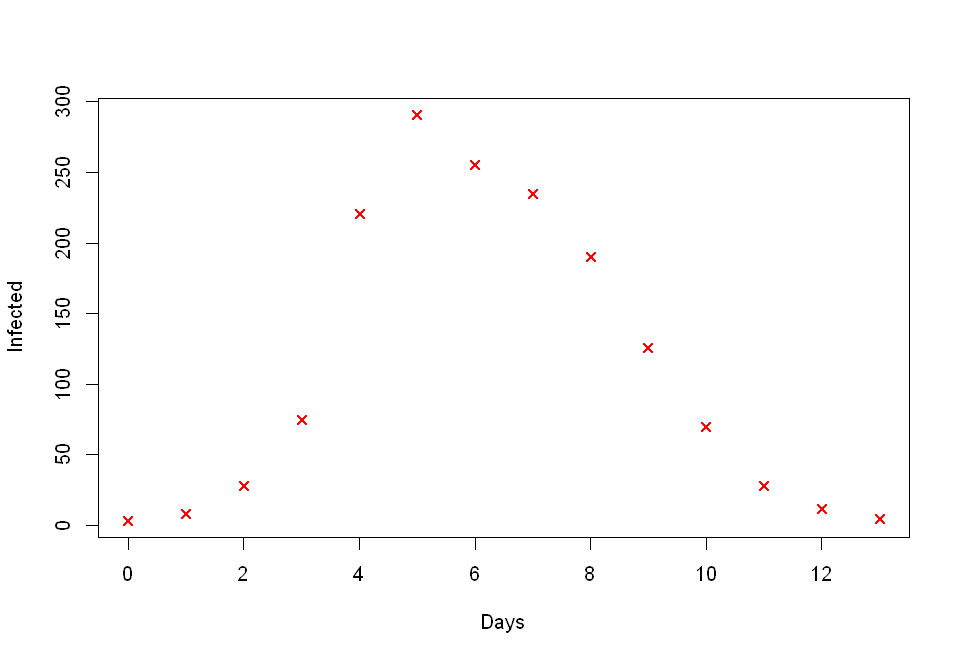

In [8]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv', header=TRUE))
N = 763
df$days <- df$days - 1
initial_conditions <- c(X=(N-df$cases[1]), Y=df$cases[1], Z=0)
plot(df$days, df$cases, xlab='Days', ylab='Infected', col='red', pch=4, lwd=1.6)

In [9]:
compare_model <- function(predicted, title, times){
    plot(df$days, df$cases, xlab='Days', ylab='Cases', col='red', lwd=1.6, pch=4)
    legend(1, 250, legend=c("Predicted", "Actual"),
           col=c("red", "grey"), lty=1:5, y.intersp=2)
    
    lines(loess(predicted~times), col='black', lty=5)
    title(title)
}

## Using Least Squares
We can use Least Squares to estimate our parameters, and then in further approaches use these parameters as our initial conditions.

In [10]:
ss <- function(params) {
  I0 <- df$cases[1]
  times <- df$days
  predictions <- model(beta = params[1], gamma = params[2], initial_conditions,times = df$days)
  sum((predictions$Y[-1] - df$cases[-1])^2)
}

In [11]:
starting_param_val <- c(1, 1)
ss_optim <- optim(starting_param_val, ss)
parameters_ss <- c(beta=ss_optim$par[1], gamma=ss_optim$par[2])
ss_optim$value

[1] 3923.88

beta     gamma 
1.6926558 0.4506558

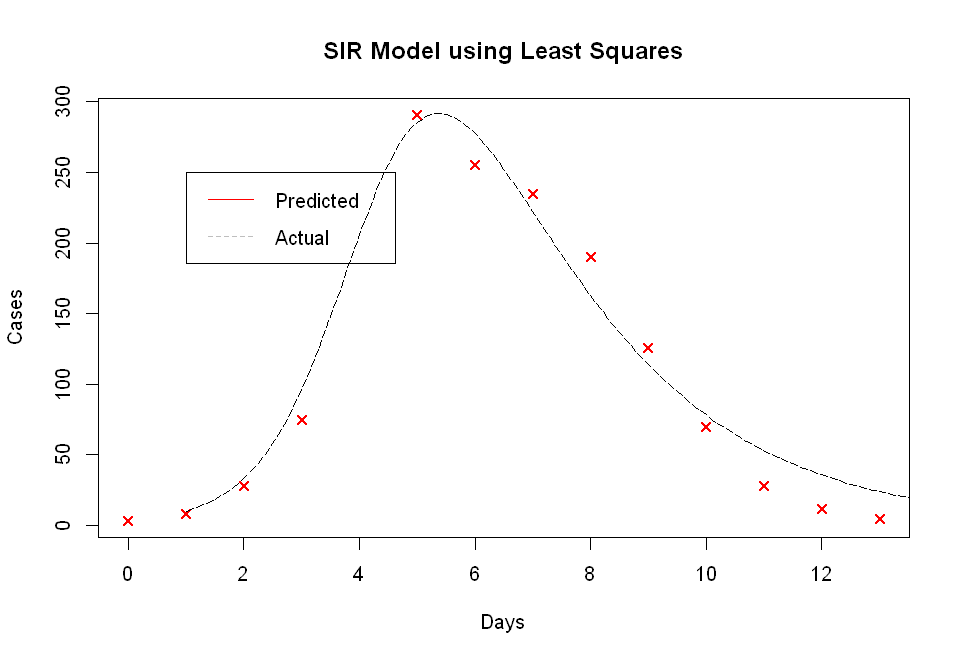

In [12]:
times <- seq(1,20,0.1)
ss_model <-model(gamma=as.double(parameters_ss['gamma']),
                       beta=as.double(parameters_ss['beta']),
                       times = times,
                       initial_conditions=initial_conditions)
parameters_ss
compare_model(ss_model$Y, "SIR Model using Least Squares", times)

## Using Normal MLE 
Now we have our initial parameter guesses in `parameters_ss`. If we assume our errors are normally distributed:

In [13]:
normalLL <- function(beta, gamma, sigma){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}

beta       gamma       sigma      logLik         AIC 
  1.6926615   0.4506834  17.3740956  55.5604643 117.1209286

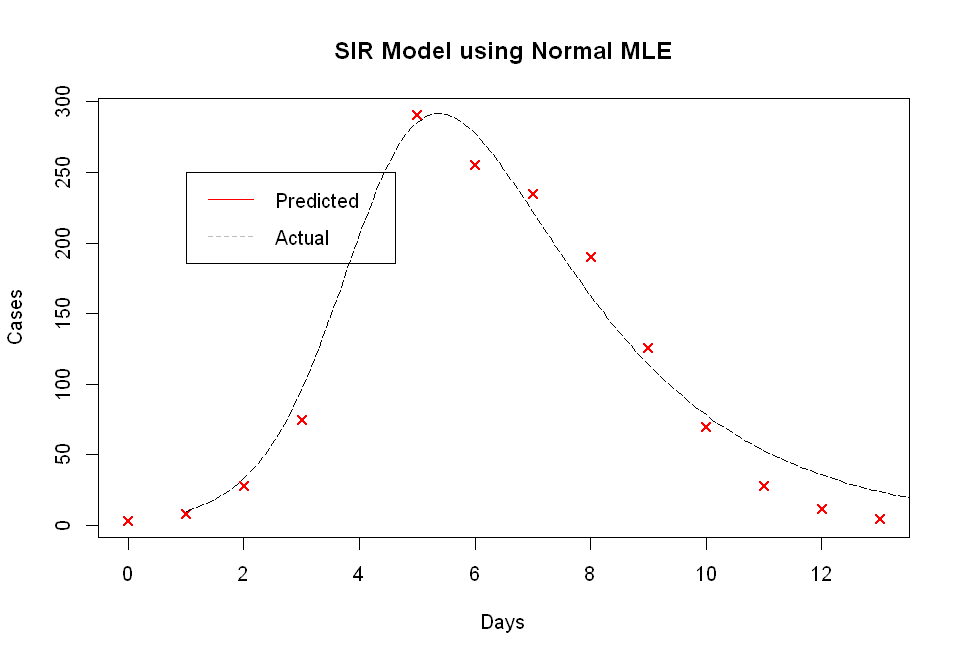

In [14]:
starting_param_val <- c(ss_optim$par, 10)
nMLL <- function(params) normalLL(params[1], params[2], params[3])

normal_optim <- optim(starting_param_val, nMLL, lower=c(0,0,1),
                 upper=c(10,10,1000),
                 method="L-BFGS-B",)
normal_params<-c(beta=(normal_optim$par[1]), gamma=(normal_optim$par[2]), sigma=(normal_optim$par[3]), logLik=normal_optim$value, AIC=6+2*normal_optim$value)
normal_params

normal_model <-c(as.double(model(gamma=as.double(normal_params['gamma']),
                       beta=as.double(normal_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(normal_model, "SIR Model using Normal MLE", times)


## Poisson MLE

In [84]:
poissonLL <- function(beta, gamma){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dpois(x = df$cases[-1], lambda = model_data, log = TRUE))
}

pLL <- function(params) poissonLL(params[1], params[2])
betas = seq(0, 2, 0.01)
gammas = seq(0, 1, 0.01)
mat <- array(0, dim=c(length(gammas),length(betas)))
for(x in seq_along(betas)){
    for(y in seq_along(gammas)){
        l <- poissonLL(betas[x],gammas[y])
        mat[y, x] <- l
    }
}

In [92]:
persp3D(gammas, betas, mat, xlab='Gamma', ylab='Beta', zlab='Negative Log Likelihood', theta=250, shade=0.6)

ERROR: Error in persp3D(gammas, betas, mat, xlab = "Gamma", ylab = "Beta", zlab = "Negative Log Likelihood", : could not find function "persp3D"


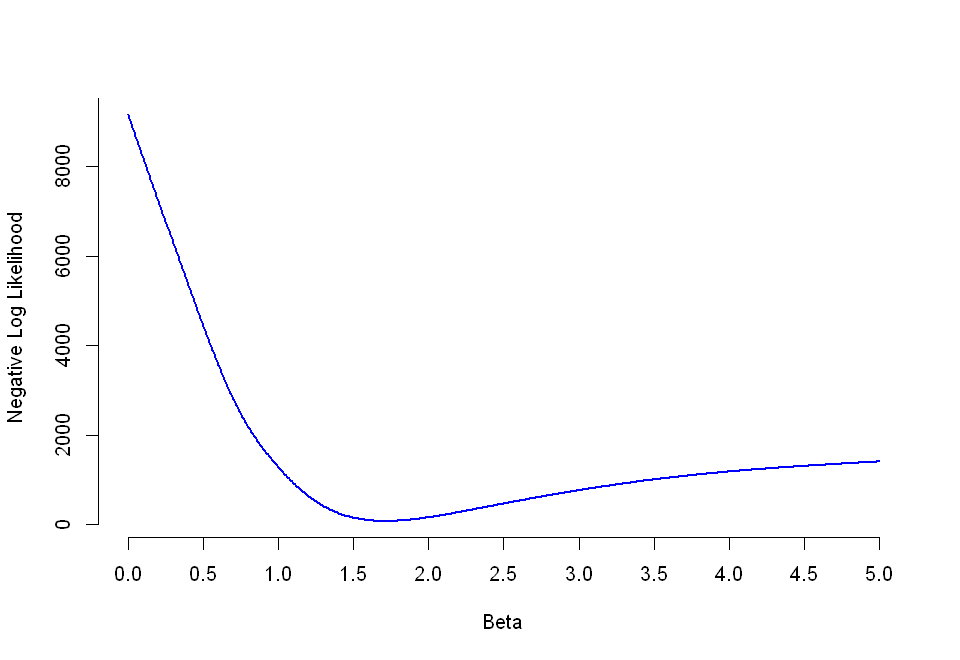

In [60]:
plot(x=betas,y=likelihoods, type='l', axes=FALSE, xlab='Beta', ylab='Negative Log Likelihood', col='blue', lwd=2)
axis(side=1, at=seq(0,5,0.5))
axis(side=2, at=seq(0, 10000, 2000))

beta      gamma     logLik        AIC 
 1.7169806  0.4795682 72.1302547 76.1302547

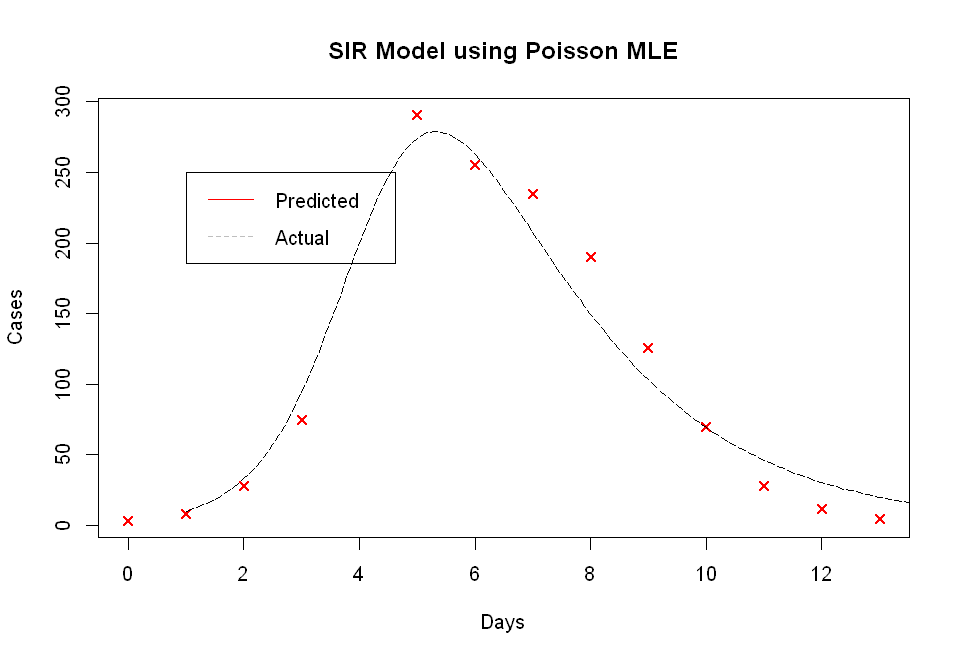

In [61]:
poisson_optim <- optim(ss_optim$par, pLL, lower=c(0,0),
                 upper=c(10,1),
                 method="L-BFGS-B",)
poisson_params<-c(beta=(poisson_optim$par[1]), gamma=(poisson_optim$par[2]), logLik=poisson_optim$value, AIC=4 + poisson_optim$value)
poisson_params

poisson_model <-c(as.double(model(gamma=as.double(poisson_params['gamma']),
                       beta=as.double(poisson_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(poisson_model, "SIR Model using Poisson MLE", times)


## Negative Binomial MLE

In [ ]:
negativeBinLL <- function(beta, gamma, dispersion){
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$Y[-1]
    -sum(dnbinom(x=df$cases[-1], s=dispersion, mu=model_data, log=TRUE))
}

nLL <- function(params) negativeBinLL(params[1], params[2], params[3])

negativeBin_optim <- optim(c(ss_optim$par,10), nLL, lower=c(0,0,-Inf),
                 upper=c(10,1, Inf),
                 method="L-BFGS-B")
negativeBin_params<-c(beta=(negativeBin_optim$par[1]), gamma=(negativeBin_optim$par[2]), dispersion=(negativeBin_optim$par[3]),logLik=negativeBin_optim$value, AIC=4 + negativeBin_optim$value)
negativeBin_params

negativeBin_model <-c(as.double(model(gamma=as.double(negativeBin_params['gamma']),
                       beta=as.double(negativeBin_params['beta']),
                       times = times,
                       initial_conditions=initial_conditions)$Y))
compare_model(negativeBin_model, "SIR Model using Negative Binomial MLE", times)


## Restricting dataset 

## Fitting on incidence
Need a new dataset for this, as the current one gives prevalence.
We can make the incidence curve though, for time $d$ where the report interval is 1. Given instantaneous incidence $C(t) = \beta S(t) I(t)$:

$C_d = \int^{d+1}_{d} C(t) dt = \int^{d+1}_{d} \beta S(t)I(t) dt$

Now say our model is calculated at $n$ points between $d+1$ and $d$, so $t_i = d+ih$ for $h=\frac{1}{n}$. Then we can apply the composite trapezium rule: 
$C_d = h[\frac{1}{2}(C(d)+C(d+1)) + \sum_{j=1}^{n-1}{C(x_j)}]$

Implementing this in R:

In [ ]:
incidence_instant <- function(beta, gamma, from, to, n=100){
    times <- seq(from, to, 1/n)
    model_data <- model(beta = beta, gamma = gamma, initial_conditions=initial_conditions, times=times)
    model_data$C <- beta*model_data$X*model_data$Y/N
    ends <- tail(model_data$C, n=1) + model_data$C[1] 
    total <- sum(model_data$C) - 0.5*ends
    return(1/n*total)
}
incidence_curve <- function(beta, gamma, times){
    inc_data <- data.frame(time=times[1], incidence=incidence_instant(beta, gamma, times[1], times[2]))
    for(i in 3:length(times)){
        instant <- incidence_instant(beta, gamma, times[i-1], times[i])
        inc_data[nrow(inc_data) + 1,] = c(times[i-1], instant)
    }
    return(inc_data)
}
time_length <- 13
incidence_times <- seq(0, time_length)
inc_data <- incidence_curve(1.66, 0.45, incidence_times)